In [20]:
from copy import deepcopy
import scipy.stats as sps
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bots.RLbot import RLPokerPlayer
from tqdm import tqdm
from pypokerengine.api.game import setup_config, start_poker
from pypokerengine.utils.card_utils import gen_cards
from pypokerengine.players import BasePokerPlayer
from baseline_players import RandomPlayer
from bots.honest_player import HonestPlayer
from bots.honest_modified_player import HonestModifiedPlayer
from bots.bot_denis_2 import BotDenisPlayer
from bots.bot1 import KoffaPlayer
from bots.bestbot import BestPlayer
from bots.forl_condition_bot_2 import ConditionPlayer
from bots.botDenis import GloomCha
from bots.forl_condition_bot import HonestStatPlayer
from bots.fish_player import FishPlayer
from bots.fold_player import FoldPlayer
from bots.bot_denis_3 import BotDenis3Player
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [3]:
# N_RANDOM_PLAYERS = 0

# config = setup_config(max_round=50, initial_stack=1500, small_blind_amount=15)
# # config.register_player(name="foldman", algorithm=FoldPlayer())
# config.register_player(name="honest", algorithm=HonestPlayer(200))
# config.register_player(name="honest_modified", algorithm=HonestModifiedPlayer(200))
# config.register_player(name="fishman", algorithm=FishPlayer())
# config.register_player(name="botDenis1", algorithm=GloomCha())
# config.register_player(name="botDenis2", algorithm=BotDenisPlayer())
# config.register_player(name="conditionPlayer", algorithm=ConditionPlayer())
# config.register_player(name="koffa", algorithm=KoffaPlayer())
# config.register_player(name="botDenis3", algorithm=BotDenis3Player())
# config.register_player(name="random", algorithm=RandomPlayer())

# for i in range(N_RANDOM_PLAYERS):
#     config.register_player(name="random" + str(i), algorithm=RandomPlayer())

In [4]:
# %%time
# from joblib import Parallel, delayed

# def f(i,config):
#     return start_poker(config, verbose=0)['players']

# def get_all_results(config, n_games=1):
#     players_stack_dict = {}
#     for player_info in config.players_info:
#         players_stack_dict[player_info['name']] = []
        
#     with Parallel(n_jobs=4) as parallel:
# #     for i in tqdm(range(n_games)):
#         data = parallel(delayed(f)(i, config) for i in range(n_games))
    
#     for i in tqdm(range(n_games)):
#         for player_info in data[i]:
#             players_stack_dict[player_info['name']].append(player_info['stack'])
            
#     return pd.DataFrame(players_stack_dict)

# res = get_all_results(config, n_games=30)

In [7]:
import sys
cur = sys.stdout
sys.stdout = open('LOG_FILE', 'w')

In [ ]:
N = 500

RLBotPark = []
DefaultBotPark = [RandomPlayer(), HonestPlayer(), FishPlayer(), 
           BotDenisPlayer(), HonestModifiedPlayer(), ConditionPlayer(), 
           GloomCha(), KoffaPlayer(), HonestStatPlayer(), BestPlayer(),
          ]

rl_score = []

mn = []


for i in range(N):
    in_model_file = None if i == 0 else 'model_{}.h5'.format(i)
    out_model_file = 'model_{}.h5'.format(i + 1)
    config = setup_config(max_round=50, initial_stack=1500, small_blind_amount=15)
    humans = list(np.random.choice(DefaultBotPark, replace=True, size=4 + max(0, 4 - len(RLBotPark))))
    rlbots = list(np.random.choice(RLBotPark, replace=True, size=min(4, len(RLBotPark)))) if len(RLBotPark) > 0 else []
#     print(humans, rlbots)
    players = humans + rlbots + [None]
    np.random.shuffle(players)
#     print(players)
    j = 0
    for player in players:
        j += 1
        if player is None:
            RLP =  RLPokerPlayer(
                study_mode=True,
                model_file=in_model_file,
                gammaReward=0.5,
                alphaUpdateNet=0.1,
                epsilonRandom=0.1,
                decayRandom=0.95,
                players=players,
                max_history_len=1000,
                new_model_file=out_model_file,
            )
            config.register_player(name='RL',algorithm=RLP)    
        else:
            config.register_player(name=str(player) + str(j), algorithm=player)
    info = start_poker(config, verbose=0)
    RLP.study_mode = False
    res = []
    for player_info in info['players']:
        res.append((player_info['name'], player_info['stack']))
    res = sorted(res, key=(lambda x:x[1]))
    print(i, res)
    for it in res:
        if it[0] == 'RL':
            mn.append(it[1])
            break
    print('mean res: {}'.format(np.mean(mn)))
#     RLP.study_mode=False
#     RLBotPark.append(
#     RLPokerPlayer(
#                 study_mode=False,
#                 model_file=in_model_file,
#                 gammaReward=0.5,
#                 alphaUpdateNet=0.1,
#                 epsilonRandom=0.1,
#                 decayRandom=0.95,
#                 players=players,
#                 max_history_len=1000,
#                 new_model_file=None,
#             )
#     )

In [16]:
mn = np.array(mn)

In [17]:
means = np.cumsum(mn)/(np.arange(len(mn)) + 1)
means2 = np.cumsum(mn**2)/(np.arange(len(mn)) + 1)
stds = (means2 - means**2) ** 0.5 

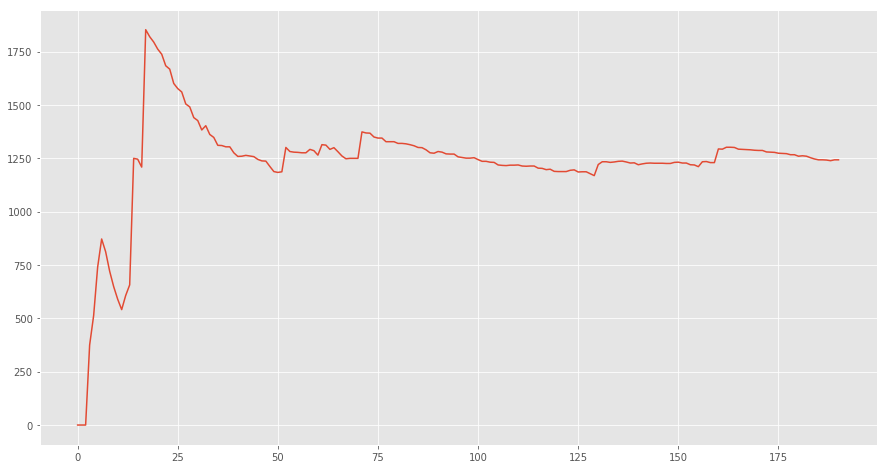

In [22]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(len(mn)), means)
# plt.plot(np.arange(len(mn)), means + stds)
# plt.plot(np.arange(len(mn)), means - stds)